# Investigating the law of large numbers by simulation

In this exercise / lecture, we’ll be simulating data to observe the law
of large numbers (LLN) in action. We’ll proceed by:

1.  Checking for univariate random variables
2.  Checking for vector-valued random variables
3.  Checking the component parts of the OLS estimator

Along the way, we’ll be particularly interested in ways the LLN — and
results which rely on it — break down.

# Scalar-valued random variables

Here’s an example of the kind of thing we’ll do today. We’ll begin by
looking at the LLN for standard normal random variables. Then, you’ll
modify this code to explore other aspects of the LLN.

In [13]:
# This is the key function to modify.  The rest is boilerplate (meaning code that is pretty much the
# same every time you use it).

# Draw a random sample mean.
#
# Inputs:
#   - n_obs: The number of independent observations that form the sample mean
#   - true_mean: The true mean of the draws.
# Returns:
#   A dataframe with three columns and one row:
#   - n: The number of samples that contributed to the sample mean
#   - value: The calculated sample mean
#   - quantity: A readable description of the random variable
DrawLLNSample <- function(n_obs, true_mean) {
  x <- rnorm(n_obs, mean=true_mean)  # <- We'll be modifying this line
  return(data.frame(n=n_obs, value=sum(x) / n_obs, quantity="normal"))
}

In [14]:
# Draw a random sample mean.
#
# Inputs:
#   - DrawFun: A function taking a single argument, the number of draws, and returning a dataframe
#       with the sample mean and other metadata
#   - n_obs_vec: A numeric vector containing the number of observations to tru
#   - num_draws: The number of independent draws to compute for each n_obs
# Returns:
#   A dataframe with the output of DrawFun, and a column indicating which draw
#   index produced that dataframe.
ConductLLNExperiment <- function(DrawFun, n_obs_vec=seq(10, 3000, by=30), num_draws=20) {
    # The rest of this can be mostly the same every time you run a univariate analysis
    lln_df <- data.frame()
    pb <- txtProgressBar(min=0, max=max(n_obs_vec), initial=0, style=3)
    for (n_obs in n_obs_vec) {
      setTxtProgressBar(pb, n_obs)
      for (draw in 1:num_draws) {
        lln_df <- bind_rows(
          lln_df,
          DrawFun(n_obs) %>% mutate(draw=draw))  
      }
    }
    close(pb)
    return(lln_df)
}

  |======================================================================| 100%

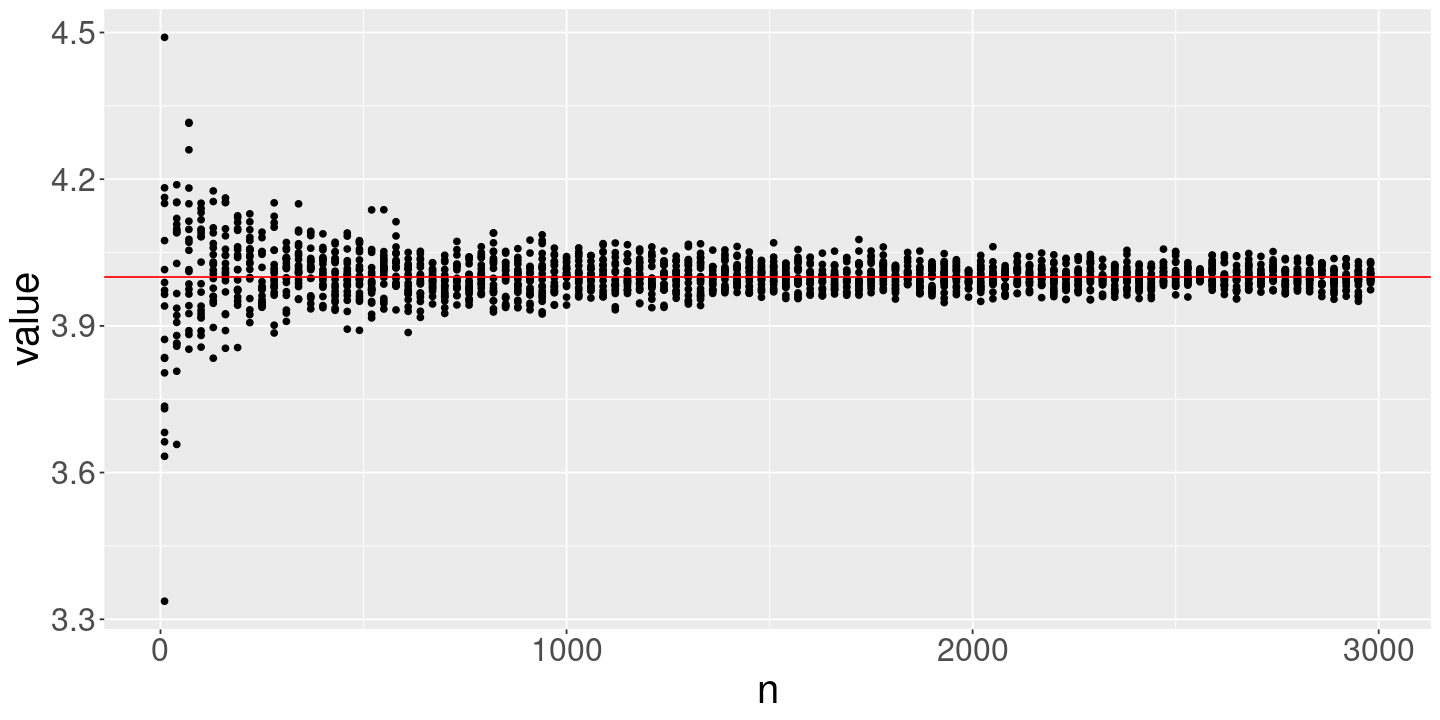

In [15]:
# Evaluate the sample average for these numbers of observations
true_mean <- 4
DrawFun <- function(n_obs) {
    DrawLLNSample(n_obs, true_mean=true_mean)
}
lln_df <- ConductLLNExperiment(DrawFun)

ggplot(lln_df) +
  geom_point(aes(x=n, y=value), alpha=1.0) +
  geom_hline(aes(yintercept=true_mean), color="red")

  |======================================================================| 100%
  |======================================================================| 100%

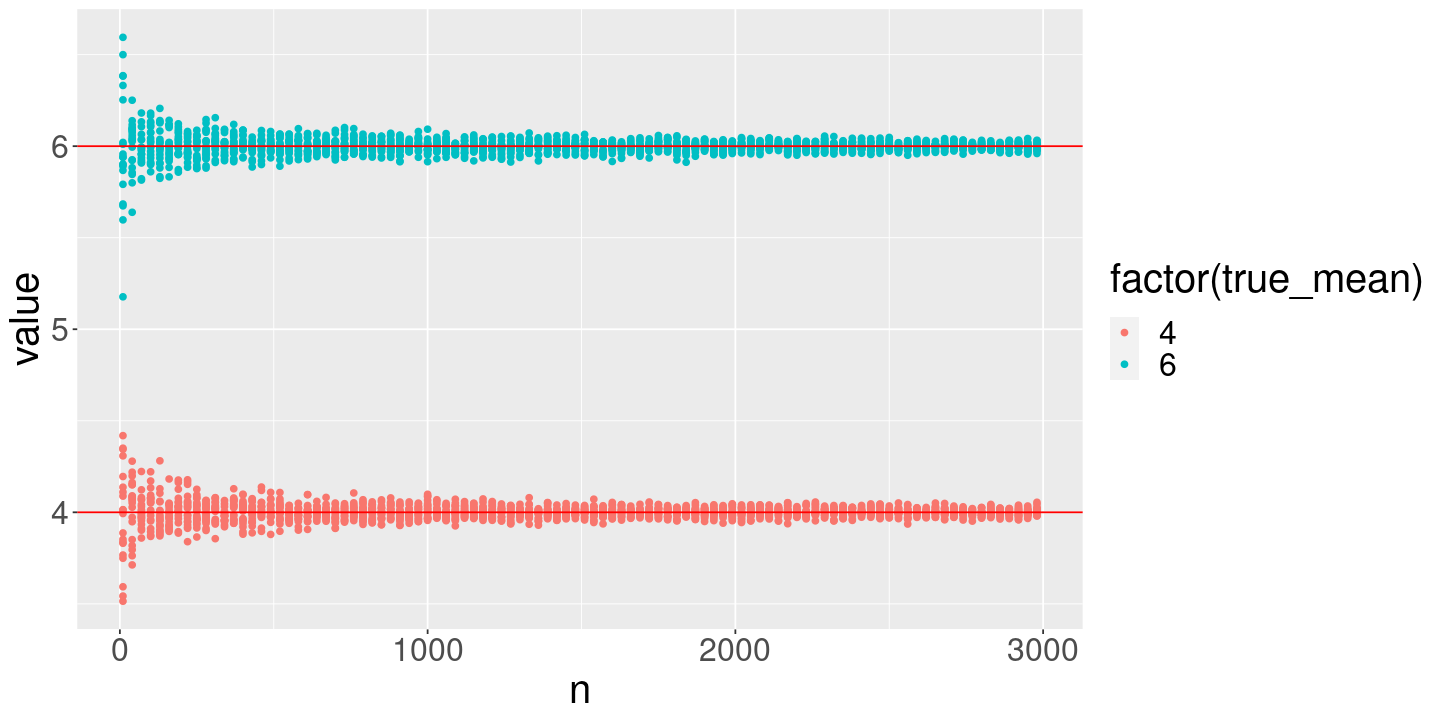

In [17]:
# A good way to compare different settings is to save them in the same dataframe
# but with a descriptive column telling them apart

lln_df <- data.frame()
DrawFun <- function(n_obs) {
    DrawLLNSample(n_obs, true_mean=true_mean)
}
for (true_mean in c(4, 6)) {
    lln_df <- bind_rows(
        lln_df,
        ConductLLNExperiment(DrawFun) %>%
        mutate(true_mean=true_mean)
        )
}

ggplot(lln_df) +
  geom_point(aes(x=n, y=value, color=factor(true_mean)), alpha=1.0) +
  geom_hline(aes(yintercept=true_mean), color="red")

### Scalar-valued random variable questions

-   How does the variance of the draws affect the convergence?
-   How does the choice of distribution affect the convergence? Some
    options to try: `rt`, `rcauchy`, `rgamma`, `runif`.
-   How do transformations affect convergence? Some to try:
    $f(x) = x^2$, $f(x) = 1 / x$, $f(x) = log(x)$, $f(x) = e^x$.
-   Can you find a random variable so that the LLN does very badly when
    estimating $1 / \overline{x}$?
-   What does the plot of $\sqrt{N} \overline{x}$ look like? How about
    $N \overline{x}$? Explain your answers.
-   Starting from, say, $N = 100$, how many observations do you need to
    cut the typical error in half?

# Vector-valued random variables

It will be useful to have these helper functions in order to convert
draws of matrix and vector-valued random variables into tidy dataframes.
Take a moment and make sure you understand what they do.

In [6]:
# Convert a matrix to a tidy dataframe.
#
# Inputs:
#   - mat: A (possibly non-square) matrix
#   - prefix: A readable name describing the matrix
# Returns:
#   - A dataframe with three columns:
#     value: The value of the matrix entry at <row>, <col>
#     component: A column containing the location <prefix>.<row>.<col> 
#     quantity: The value of <prefix> 
FlattenMatrix <- function(mat, prefix) {
  df_list <- list()
  if (!is.matrix(mat)) {
    mat <- as.matrix(mat)
  }
  for (d1 in 1:nrow(mat)) {
    for (d2 in 1:ncol(mat)) {
      df_list[[(paste0(prefix, ".", d1,  ".", d2))]] <- mat[d1, d2, drop=FALSE]
    }
  }
  return(as.data.frame(df_list) %>% 
           pivot_longer(cols=everything(), names_to="component") %>%
           mutate(quantity=prefix))
}



foo_mat <- matrix(1:6, nrow=3, ncol=2)
print(FlattenMatrix(foo_mat, "foo"))
print(foo_mat)

foo_vec <- 1:3
print(FlattenMatrix(foo_vec, "foo"))
print(foo_vec)

# A tibble: 6 × 3
  component value quantity
  <chr>     <int> <chr>   
1 foo.1.1       1 foo     
2 foo.1.2       4 foo     
3 foo.2.1       2 foo     
4 foo.2.2       5 foo     
5 foo.3.1       3 foo     
6 foo.3.2       6 foo     
     [,1] [,2]
[1,]    1    4
[2,]    2    5
[3,]    3    6
# A tibble: 3 × 3
  component value quantity
  <chr>     <int> <chr>   
1 foo.1.1       1 foo     
2 foo.2.1       2 foo     
3 foo.3.1       3 foo     
[1] 1 2 3

In [7]:
# Invert a matrix.  If the matrix is singular, return a matrix
# of NA, the same shape as the input, without terminating or raising an error.
SafeSolve <- function(mat) {
  mat_inv <- matrix(NA, nrow(mat), ncol(mat) )
  tryCatch(mat_inv <- solve(mat),
           error=function(e) { })
  return(mat_inv)
}


print(SafeSolve(diag(3)))
print(SafeSolve(matrix(0, 3, 3)))


     [,1] [,2] [,3]
[1,]    1    0    0
[2,]    0    1    0
[3,]    0    0    1
     [,1] [,2] [,3]
[1,]   NA   NA   NA
[2,]   NA   NA   NA
[3,]   NA   NA   NA

We can now do the much the same thing for vectors that we did for
scalars.

In [19]:


# Draw a random sample mean.
# Inputs:
#   - n_obs: The number of independent observations that form the sample mean
#   - true_mean: The true mean of the draws.
# Returns:
#   A dataframe with three columns and one row:
#   - n: The number of samples that contributed to the sample mean
#   - value: The calculated sample mean
#   - quantity: A readable description of the random variable
DrawLLNVectorSample <- function(n_obs, true_mean, cov_mat) {
  stopifnot(ncol(cov_mat) == nrow(cov_mat))
  stopifnot(length(true_mean) == nrow(cov_mat))
  x <- rmvnorm(n_obs, mean=true_mean, sigma=cov_mat)
  xbar <- apply(x, FUN=sum, MARGIN=2) / n_obs
  return(FlattenMatrix(xbar, "xbar") %>%
           mutate(n=n_obs, quantity="xbar"))
}

In [20]:
# Set some parameters and sanity check the output
x_dim <- 3
true_mean <- 1:x_dim
cov_mat <- diag(x_dim)
DrawLLNVectorSample(10, true_mean, cov_mat)

  |======================================================================| 100%

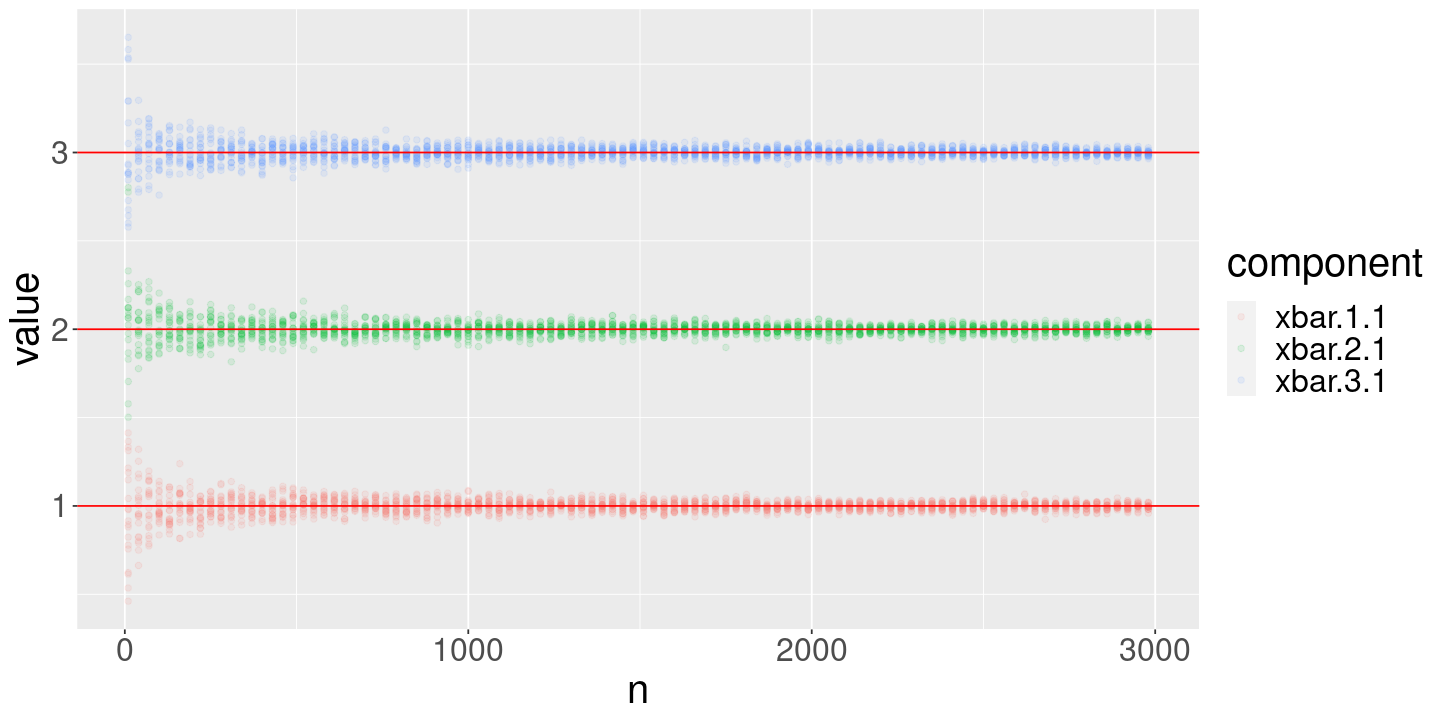

In [21]:
# Evaluate the sample average for these numbers of observations
DrawFun <- function(n_obs) {
    DrawLLNVectorSample(n_obs, true_mean=true_mean, cov_mat=cov_mat)
}
lln_df <- ConductLLNExperiment(DrawFun)

ggplot(lln_df) +
  geom_point(aes(x=n, y=value, color=component), alpha=0.1) +
  geom_hline(aes(yintercept=value), color="red",
             data=FlattenMatrix(true_mean, "xbar"))


## Some vector LLN questions:

-   How does the covariance matrix affect convergence? Try:
    -   Highly correlated observations
    -   A nearly singular matrix
-   How do transformations affect convergence? Some to try: inverse,
    eigenvalues, sum of squares of entries, eigenvectors.
-   Can you find a covariance matrix for which the LLN does very badly
    with the inverse?

# Regeression

Now, let’s investigate the components of regression using the same
tools.

In [11]:
x_dim <- 2
x_cov <- matrix(0.2, nrow=x_dim, ncol=x_dim) + diag(x_dim)
beta_true <- 1:x_dim / x_dim
sigma_true <- 3.0

DrawRegressionResult <- function(n_obs, x_cov, beta_true, sigma_true) {
  x_mat <- rmvnorm(n_obs, sigma=x_cov)
  eps_true <- rnorm(n_obs, mean=0, sd=sigma_true)
  y_vec <- x_mat %*% beta_true + eps_true
  
  xtx_mean <- t(x_mat) %*% x_mat / n_obs
  
  return(FlattenMatrix(xtx_mean, prefix="xtx") %>% mutate(n=n_obs))
}

# Sanity check
DrawRegressionResult(10, x_cov=x_cov, beta_true=beta_true, sigma_true=sigma_true)

  |======================================================================| 100%

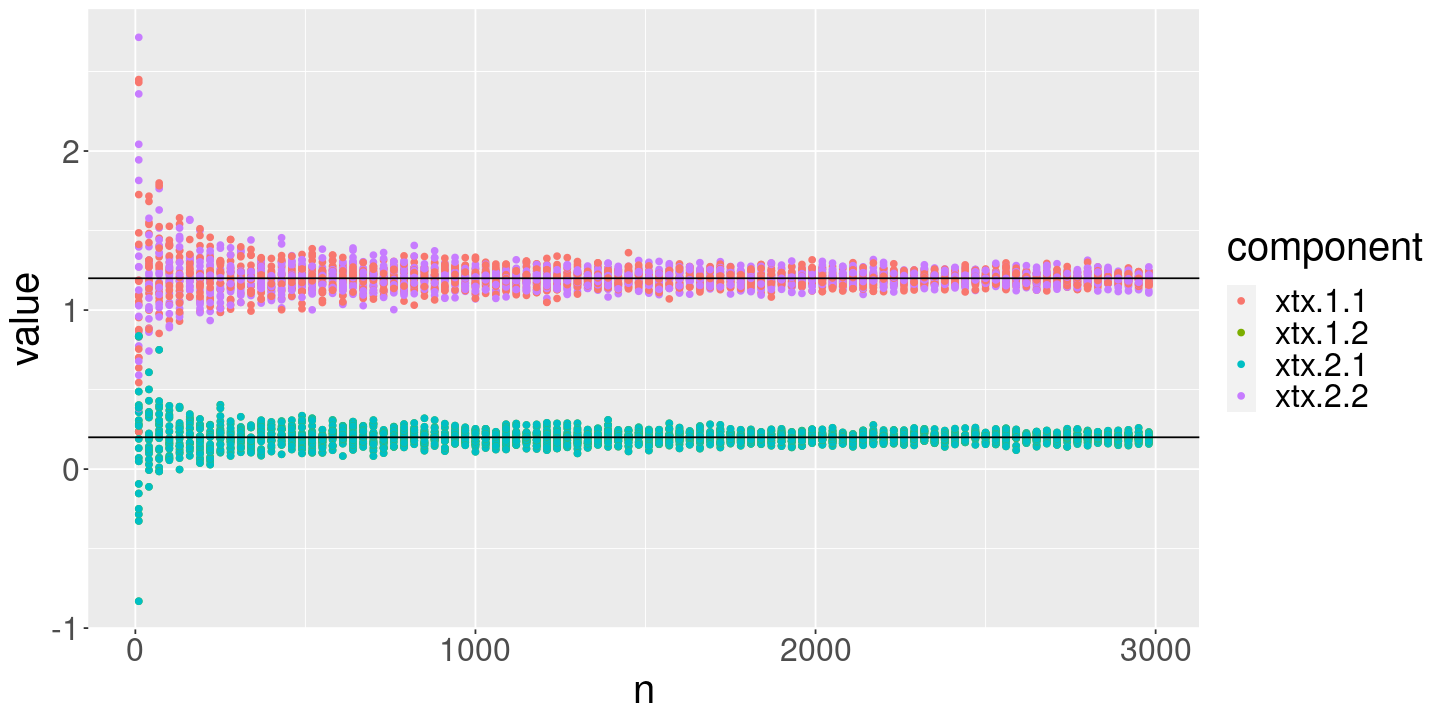

In [22]:
xtx_limit <- FlattenMatrix(x_cov, prefix="xtx")


# Evaluate the sample average for these numbers of observations
DrawFun <- function(n_obs) {
    DrawRegressionResult(n_obs, x_cov=x_cov, beta_true=beta_true, sigma_true=sigma_true)
}
lln_df <- ConductLLNExperiment(DrawFun)

ggplot(lln_df) +
  geom_point(aes(x=n, y=value, color=component, group=interaction(draw, component))) +
  geom_hline(aes(yintercept=value), data=xtx_limit)


Using the template above, show convergence of the following quantities:

-   X^T X / N
-   ((X^T X) / N)^{-1}
-   X^T Y / N
-   betahat
-   yhat_new = betahat x_new for some fixed x_new
-   yhat_new - y_new = for some fixed x_new

### Regression questions

-   What happens if the residuals have high variance?
-   What happens if the x covariance is nearly singular?
-   What happens if you are missing a regressor (i.e. misspecified
    model)?